In [ ]:
# Mount Drive using this statement
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
# create directory for cloning yolov7 
import os

if not os.path.isdir("MidPrepCloudPhysician"):
  os.makedirs("MidPrepCloudPhysician")

In [ ]:
# folder where yolov7 will clone
%cd /content/gdrive/MyDrive/MidPrepCloudPhysician

/content/gdrive/MyDrive/MidPrepCloudPhysician


In [ ]:
# clonning yolov7
!git clone https://github.com/WongKinYiu/yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.93 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (522/522), done.
Updating files: 100% (104/104), done.


In [ ]:
# yolov7 folder
%cd /content/gdrive/MyDrive/MidPrepCloudPhysician/yolov7

/content/gdrive/MyDrive/MidPrepCloudPhysician/yolov7


In [ ]:
!pip install gdown
import gdown
# Download features model weights https://drive.google.com/file/d/16GUeuwY6ezlMxXAlzwBOnVIBHLd2Vivg/view?usp=sharing
gdown.download("https://drive.google.com/uc?id=16GUeuwY6ezlMxXAlzwBOnVIBHLd2Vivg&confirm=t", "Feature_weights.pt", quiet=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=16GUeuwY6ezlMxXAlzwBOnVIBHLd2Vivg&confirm=t
To: /content/gdrive/MyDrive/MidPrepCloudPhysician/yolov7/Feature_weights.pt
100%|██████████| 74.8M/74.8M [00:01<00:00, 41.6MB/s]


'Feature_weights.pt'

In [ ]:
# download monitor model weights https://drive.google.com/file/d/1qcnxbJ9h9EfKf9K6BDUZBDGCnP2VGxbA/view?usp=sharing
gdown.download("https://drive.google.com/uc?id=1qcnxbJ9h9EfKf9K6BDUZBDGCnP2VGxbA&confirm=t", "monitor_weights.pt", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1qcnxbJ9h9EfKf9K6BDUZBDGCnP2VGxbA&confirm=t
To: /content/gdrive/MyDrive/MidPrepCloudPhysician/yolov7/monitor_weights.pt
100%|██████████| 74.8M/74.8M [00:01<00:00, 52.9MB/s]


'monitor_weights.pt'

In [ ]:
 pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.68
    Uninstalling opencv-python-headless-4.7.0.68:
      Successfully uninstalled opencv-python-headless-4.7.0.68


In [ ]:
import numpy as np 
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans
import easyocr
import ast
import pandas as pd
import argparse
import time
from pathlib import Path
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import sys
sys.path.append('/content/gdrive/MyDrive/MidPrepCloudPhysician/yolov7/models')  
import models
import cv2
from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel
import copy 
import time

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image

In [ ]:

classes_to_filter = [] 

# Monitor extraction model parameters
opt_monitor  = {
    
    "weights": "/content/gdrive/MyDrive/MidPrepCloudPhysician/yolov7/monitor_weights.pt", 
    "yaml"   : "data/custom_data.yaml",
    "img-size": 640, 
    "conf-thres": 0.25, 
    "iou-thres" : 0.45, 
    "device" : 'cpu',  
    "classes" : classes_to_filter  

}
# Feature extraction model parameters 
opt_features  = {
    
    "weights": "/content/gdrive/MyDrive/MidPrepCloudPhysician/yolov7/Feature_weights.pt", 
    "yaml"   : "data/custom_data.yaml",
    "img-size": 640, 
    "conf-thres": 0.25, 
    "iou-thres" : 0.45, 
    "device" : 'cpu',  
    "classes" : classes_to_filter  

}

# Class labels for feature extraction model
feature_classes = {
    0:"HR",
    1:"SBP",
    2:"DBP",
    3:"MAP",
    4:"SPO2",
    5:"RR",
    6:"HR_W",
    7:"RR_W", 
    8:"SPO2_W"

}

In [ ]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    '''
    Function responsible for image preprocessing.
    Args: 
      img: image file  
    Returns:
      img: Processed image
      ratio: Image Scale ratio 
      (dw,dh)
    '''

    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [ ]:
# Function for loading models
def Load_model(opt):
  '''
    Function responsible for loading models.
    Args: 
      opt: Model parameters, dict
    Returns:
      model: Loaded model
  '''

  with torch.no_grad():
    weights, imgsz = opt['weights'], opt['img-size']
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'
    model = attempt_load(weights, map_location=device)  
  
    if half:
      model.half()
  return model

In [ ]:
# loading the monitor screen extraction model
monitor_model = Load_model(opt_monitor)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


In [ ]:
# loading the feature extraction(from monitor screen) model 
feature_model = Load_model(opt_features)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


In [ ]:
def get_predictions(image, model, opt):
  '''
  Function responsible for making predictions from model.
  Args:  
    image: image file
    model: Loaded model
    opt: Model Parameters, dict
  Returns:
    img0: Labelled image with predicted bounding boxes, image file
    pred: Model predictions, Tensor
  '''
  img0 = copy.copy(image)
  imgsz = opt['img-size']
  stride = int(model.stride.max())
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  img = letterbox(img0, imgsz, stride=stride)[0]
  img = img[:, :, ::-1].transpose(2, 0, 1)  
  img = np.ascontiguousarray(img)
  img = torch.from_numpy(img).to(device)
  img = img.half() if half else img.float()  
  img /= 255.0  # 0 - 255 to 0.0 - 1.0
  if img.ndimension() == 3:
    img = img.unsqueeze(0)
  t1 = time_synchronized()
  pred = model(img, augment= False)[0]

  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:

      classes.append(names.index(class_name))

  if classes:
    
    classes = [i for i in range(len(names)) if i not in classes]
  
  pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= None, agnostic= False)
  t2 = time_synchronized()
  for i, det in enumerate(pred):
    s = ''
    s += '%gx%g ' % img.shape[2:]  
    gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
    if len(det):
      det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

      for c in det[:, -1].unique():
        n = (det[:, -1] == c).sum()  
        s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  
    
      for *xyxy, conf, cls in reversed(det):

        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=1)

  return img0, pred

In [ ]:
def get_cropped_feature_image(image, model = monitor_model, model1 = feature_model, opt = opt_monitor, opt1 = opt_features):
  '''
  Function responsible for getting monitor screen, feature predicted image and its predictions.
  Args:  
    image: image file
    model: Monitor extraction model
    model1 = feature extraction model  
    opt: Monitor extraction model Parameters, dict
    opt1: feature extraction model Parameters, dict
  Returns:
    cropped: Cropped image(monitor image), image file
    img1: feature predicted monitor image
    pred1: feature predictions, Tensor
  ''' 
  img0, pred = get_predictions(image, model, opt)
  pred_np = pred[0][:, :6].cpu().detach().numpy()
  x, y, w, h = int(pred_np[0][0]), int(pred_np[0][1]), int(pred_np[0][2]), int(pred_np[0][3])
  cropped = img0[y:h,x:w]
  img1, pred1 = get_predictions(cropped, model1, opt1)
  
  return cropped, img1, pred1
  

In [ ]:
def features_dataframe(pred):
  '''
  Function responsible for converting feature prediction tensor to dataframe.
  Args:  
    pred: Feature prediction tensor 
  Returns:
    df: Pandas dataframe containing bounding box coordinates of predicted features in monitor screen
    confidence_scrore: Stores highest confidence score of each predicted class, dict 
  '''
  pred_np = pred[0][:, :6].cpu().detach().numpy() # Numpy array of all predictions
  columns = ['image_name', 'HR', 'SBP', 'DBP', 'MAP', 'SPO2', 'RR', 'HR_W', 'RR_W', 'SPO2_W']
  df = pd.DataFrame(columns=columns)
  df = df.append({'image_name': 'test_image'}, ignore_index=True) 

  no_rows = pred_np.shape[0]

  labels=[]
  coords=[]
  confidence_score = {}
  for i in range(0,no_rows):
    pred_arr = pred_np[i]
    label = pred_arr[5]
    conf = pred_arr[4]
    if conf > confidence_score.get(label,0):
      confidence_score[label] = conf
      coordinates = pred_arr[0:4]
      coord = []
      for j in coordinates:
        coord.append(j)
      df.loc[0,feature_classes[label]] = f'{coord}'
  
  return df, confidence_score


In [ ]:
# Loading easyocr model
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
def pipeline(img, df):
    '''
    Function responsible for detecting numbers from the predicted feature image.
    Args:  
      img: Monitor screen image
      df: Pandas dataframe containing bounding box coordinates of predicted features in monitor screen
    Returns:
      output: Output dictionary containing feature numbers for each class, eg: {'HR': '102', 'SPO2': '96', 'RR': '18'}
      
    '''
  
    output = {}
    lst = ['HR', 'SBP', 'DBP', 'MAP', 'SPO2', 'RR']
    
    for j in range(6):
      if pd.isna(df.iat[0, j+1]) == False:
          x1,y1,x2,y2 = ast.literal_eval(df.iat[0, j+1])
          cropped_img = img[int(y1):int(y2), int(x1):int(x2)]
          result = reader.readtext(cropped_img)
          if len(result) != 0:
            cleaned_string = ""
            for char in result[0][1]:
              try:
                int(char)
                cleaned_string += char
              except ValueError:
                pass
            print(f"{lst[j]} identified")
            if (j == 1):
              if len(cleaned_string)== 4:
                output[lst[j]] = cleaned_string[:3]
              else:
                output[lst[j]] = cleaned_string
            else:
                output[lst[j]] = cleaned_string

    return output

In [ ]:
# Main inference Function. Only provide input image path to this function 
def inference(image_path, mon_model = monitor_model, fea_model = feature_model,opt = opt_monitor, opt1 = opt_features): 
  '''
  Function responsible for inference.
  Args:  
    image_path: Path of the test image
    "Rest all inputs are default parameters. Don't change them"
  Returns:
    output_df: Output dictionary containing feature numbers for each class, eg: {'HR': '102', 'SPO2': '96', 'RR': '18'}
  '''
  image = cv2.imread(image_path)
  monitor_image, img1, pred1 = get_cropped_feature_image(image, model = mon_model, model1 = fea_model, opt = opt_monitor, opt1 = opt_features)
  df, confi = features_dataframe(pred1)
  output_df = pipeline(monitor_image, df)
  return output_df

In [ ]:
# Running inference on test image 
output = inference('/content/gdrive/MyDrive/adityawarangal_icu_mon--02_2023_1_2_8_15_26.jpeg') # Just enter the path of the test image 
output

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


HR identified
SBP identified


{'HR': '111', 'SBP': '100'}

##Graph digitization 


In [ ]:
# Loading and processing data for graph digitization
image_path = "Image Path" # Enter the same test image path as mentioned above in inference function
image = cv2.imread(image_path)

img0, pred = get_predictions(image, monitor_model, opt_monitor)
pred_np = pred[0][:, :6].cpu().detach().numpy()
x, y, w, h = int(pred_np[0][0]), int(pred_np[0][1]), int(pred_np[0][2]), int(pred_np[0][3])
cropped_image = img0[y:h,x:w]
#cv2_imshow(cropped_image)
img1, pred1 = get_predictions(cropped_image, feature_model, opt_features)
df, confi = features_dataframe(pred1)
df

,image_name,HR,SBP,DBP,MAP,SPO2,RR,HR_W,RR_W,SPO2_W
0,test_image,"[334.0, 50.0, 382.0, 85.0]","[327.0, 88.0, 380.0, 122.0]",NaN,"[76.0, 268.0, 138.0, 289.0]",NaN,NaN,"[13.0, 44.0, 367.0, 74.0]",NaN,"[0.0, 222.0, 336.0, 268.0]"


In [ ]:
def return_df_image(image_path,monitor_model = monitor_model,
                    feature_model = feature_model, 
                    opt_monitor = opt_monitor, 
                    opt_features = opt_features):
    
    image = cv2.imread(image_path)
    img0, pred = get_predictions(image, monitor_model, opt_monitor)
    pred_np = pred[0][:, :6].cpu().detach().numpy()
    x, y, w, h = int(pred_np[0][0]), int(pred_np[0][1]), int(pred_np[0][2]), int(pred_np[0][3])
    img = img0[y:h,x:w]
    #cv2_imshow(cropped_image)
    img1, pred1 = get_predictions(img, feature_model, opt_features)
    df, confi = features_dataframe(pred1)
    fig = graph_digitise(img,df)
    return fig 


In [ ]:
def graph_digitise(img,df):
    '''
    Function responsible for graph digitization.
    Args:  
      img: Monitor screen image
      df: Pandas dataframe containing bounding box coordinates of predicted features in monitor screen
    Returns:
      fig: Digitized graph
    '''
    for j in range(6,7):
      if pd.isna(df.iat[0, j+1]) == False:
          x1,y1,x2,y2 = ast.literal_eval(df.iat[0, j+1])
          cropped_img = img[int(y1):int(y2), int(x1):int(x2)]
          pixels = np.array(cropped_img)
          
          ## Thresholding
          pixels_2d = pixels.reshape(-1, pixels.shape[-1]).astype(np.float32)
          black_threshold = 10
          black_pixels = pixels_2d[np.all(pixels_2d <= black_threshold, axis=1)]
          non_black_pixels = pixels_2d[np.any(pixels_2d > black_threshold, axis=1)]
          num_colors = 1
          centroids, _ = kmeans(non_black_pixels, num_colors)
          
          ## Creating mask and filling values 
          value = centroids[0]
          range_ = 55
          mask = np.logical_or(pixels[..., 0] < value[0]-range_, pixels[..., 0] > value[0]+range_)
          mask = np.logical_or(mask, np.logical_or(pixels[..., 1] < value[1]-range_, pixels[..., 1] > value[1]+range_))
          mask = np.logical_or(mask, np.logical_or(pixels[..., 2] < value[2]-range_, pixels[..., 2] > value[2]+range_))
          extracted_portion = np.where(mask[..., np.newaxis], [0, 255, 0], [0, 0, 0])
          
          ## Getting co-ordinates
          img = cv2.convertScaleAbs(extracted_portion, alpha=(255.0))
          _, threshold = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)

          kernel = np.ones((1, 1), np.uint8)
          threshold = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)

          coords = np.column_stack(np.where(extracted_portion > 0))
          x = coords[:, 1]
          y = coords[:, 0]
          df = pd.DataFrame({'x': x, 'y': y})
          df = df.drop_duplicates()

          ## Using DBscan clustering algo
          db = DBSCAN(eps=5, min_samples=5).fit(np.column_stack([x, y]))
          core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
          core_samples_mask[db.core_sample_indices_] = True
          unique_labels = set(db.labels_)
          colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
          plt.figure(figsize=(10,1), dpi=100)
          fig, ax = plt.subplots(figsize=(10,1))
          for k, col in zip(unique_labels, colors):
            class_member_mask = (db.labels_ == k)
            xy = np.column_stack([x[class_member_mask & core_samples_mask], y[class_member_mask & core_samples_mask]])
            ax.plot(xy[:, 0], extracted_portion.shape[0]-xy[:, 1], '.', markerfacecolor=tuple(col), markersize=2)
            plt.show()
          return fig
      else:
        return ('HR not found')

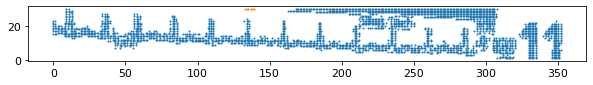

In [ ]:
#Plotting the digitized graph
f = return_df_image('/content/gdrive/MyDrive/adityawarangal_icu_mon--02_2023_1_2_8_15_26.jpeg')
f